<a href="https://colab.research.google.com/github/akankshaUniyal20/Mircrobes_Identification/blob/main/MicrobesIdentification_Using_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Importing Libraies

In [ ]:
import os,glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from random import randint
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback,EarlyStopping
from tensorflow.keras.preprocessing.image import img_to_array,load_img
from sklearn.metrics import classification_report
import numpy as np
from cv2 import resize
from os import path, listdir

#Loading Dataset

In [ ]:
dataset_Path = "/content/drive/My Drive/MicrobesIdentification/Dataset"

In [ ]:
name_class = os.listdir(dataset_Path)

In [ ]:
dataset_Path = list(glob.glob(dataset_Path+'/**/*.*'))

In [ ]:
labels = list(map(lambda x : os.path.split(os.path.split(x)[0])[1],dataset_Path))

In [ ]:
dataset_Path = pd.Series(dataset_Path,name = 'FilePath').astype(str)
labels = pd.Series(labels,name='Label')
data = pd.concat([dataset_Path,labels],axis =1)
data = data.sample(frac=1).reset_index(drop= True)
data.head(5)

,FilePath,Label
0,/content/drive/My Drive/MicrobesIdentification...,Paramecium
1,/content/drive/My Drive/MicrobesIdentification...,Spherical_Bacteria
2,/content/drive/My Drive/MicrobesIdentification...,Euglena
3,/content/drive/My Drive/MicrobesIdentification...,Spiral_Bacteria
4,/content/drive/My Drive/MicrobesIdentification...,Paramecium


In [ ]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i]-10,y[i], ha = 'center')

In [ ]:
counts = data.Label.value_counts()

In [ ]:
counts.index

Index(['Euglena', 'Paramecium', 'Spherical_Bacteria', 'Rod_Bacteria', 'Hydra',
       'Spiral_Bacteria', 'Yeast', 'Amoeba'],
      dtype='object')

#Data Visualization

Text(0, 0.5, 'label')

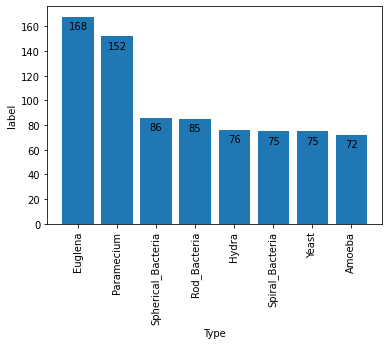

In [ ]:
plt.bar(counts.index, counts)
addlabels(counts.index, counts)
plt.xticks(rotation=90)
plt.xlabel('Type')
plt.ylabel('label')

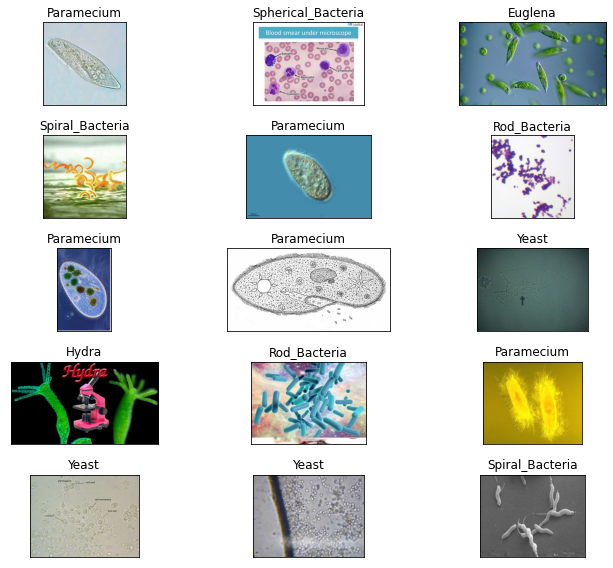

In [ ]:
fig,axes = plt.subplots(nrows=5,ncols=3,figsize=(10,8),subplot_kw={'xticks':[],'yticks':[]})
for i ,ax,in enumerate(axes.flat):
  ax.imshow(plt.imread(data.FilePath[i]))
  ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

#Spliting dataset and Image augmentation on training,validating data

In [ ]:
train,rem = train_test_split(data,test_size =0.20,random_state = 42 )
test,valid = train_test_split(data,test_size =0.50,random_state = 42 )

In [ ]:
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=10,
)
test_datagen = ImageDataGenerator()

In [ ]:
train_gen = train_datagen.flow_from_dataframe(dataframe = train,x_col = 'FilePath',y_col = 'Label',target_size=(224,224),
                                              class_mode ='categorical', color_mode='rgb',batch_size =8,shuffle = True,seed =42)
valid_gen = train_datagen.flow_from_dataframe(dataframe = valid,x_col = 'FilePath',y_col = 'Label',target_size=(224,224),
                                              class_mode ='categorical', color_mode='rgb',batch_size =8,shuffle = False,seed =42)
test_gen =  test_datagen.flow_from_dataframe(dataframe = test,x_col = 'FilePath',y_col = 'Label',target_size=(224,224),
                                             class_mode ='categorical', color_mode='rgb',batch_size =8,shuffle = False,seed =42)

Found 631 validated image filenames belonging to 8 classes.
Found 395 validated image filenames belonging to 8 classes.
Found 394 validated image filenames belonging to 8 classes.


#Model Training

In [ ]:
NO_CLASSES = max(train_gen.class_indices.values()) + 1
base_model = VGG16(include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)       
x = Dense(1024,activation='relu')(x)       
x = Dense(512,activation='relu')(x)  
preds = Dense(NO_CLASSES,activation='softmax')(x) 
model = Model(inputs = base_model.input, outputs = preds)
for layer in model.layers[:19]:
    layer.trainable=False
for layer in model.layers[19:]:
    layer.trainable=True

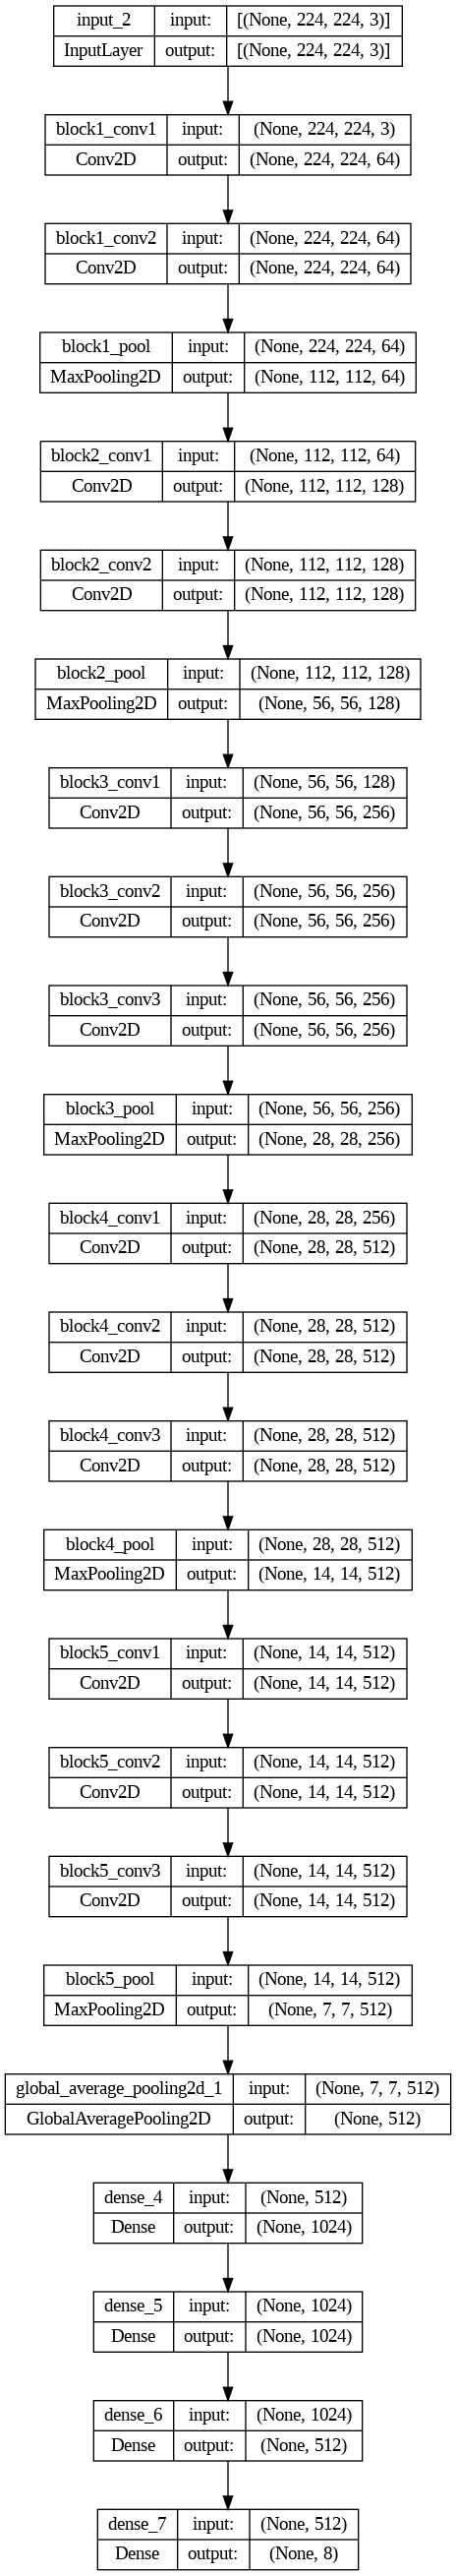

In [ ]:
tf.keras.utils.plot_model(model,'model.png',show_shapes=True)

In [ ]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
my_callbacks = [EarlyStopping(monitor = 'val_accuracy',min_delta=0,patience=2,mode='auto')]

In [ ]:
model.fit(train_gen,validation_data = valid_gen,
          epochs=25,callbacks=[my_callbacks])

Epoch 1/25
79/79 [==============================] - 544s 7s/step - loss: 2.5750 - accuracy: 0.4326 - val_loss: 1.0428 - val_accuracy: 0.6582
Epoch 2/25
79/79 [==============================] - 538s 7s/step - loss: 0.9329 - accuracy: 0.6862 - val_loss: 0.8922 - val_accuracy: 0.7114
Epoch 3/25
79/79 [==============================] - 535s 7s/step - loss: 0.6918 - accuracy: 0.7702 - val_loss: 0.9134 - val_accuracy: 0.7241
Epoch 4/25
79/79 [==============================] - 536s 7s/step - loss: 0.4592 - accuracy: 0.8542 - val_loss: 1.0637 - val_accuracy: 0.7139
Epoch 5/25
79/79 [==============================] - 535s 7s/step - loss: 0.4673 - accuracy: 0.8605 - val_loss: 0.7977 - val_accuracy: 0.7797
Epoch 6/25
79/79 [==============================] - 537s 7s/step - loss: 0.3941 - accuracy: 0.8716 - val_loss: 0.7874 - val_accuracy: 0.8076
Epoch 7/25
79/79 [==============================] - 540s 7s/step - loss: 0.3230 - accuracy: 0.8986 - val_loss: 0.8312 - val_accuracy: 0.8101
Epoch 8/25
79

In [ ]:
model.evaluate(test_gen)

50/50 [==============================] - 204s 4s/step - loss: 0.1873 - accuracy: 0.9518


[0.1873117834329605, 0.9517766237258911]

In [ ]:
#predict the label of the test_gen
pred = model.predict(test_gen) 
pred = np.argmax(pred,axis=1)
labels = (train_gen.class_indices) 
labels = dict((v,k) for k,v, in labels.items()) 
pred = [labels[k]for k in pred]

50/50 [==============================] - 204s 4s/step


In [ ]:
y_test = list(test.Label)
print(classification_report(y_test,pred))

                    precision    recall  f1-score   support

            Amoeba       0.97      1.00      0.99        36
           Euglena       0.97      0.99      0.98        79
             Hydra       0.97      0.87      0.92        38
        Paramecium       0.94      0.98      0.96        84
      Rod_Bacteria       0.97      0.92      0.94        36
Spherical_Bacteria       0.86      0.98      0.91        43
   Spiral_Bacteria       0.98      0.98      0.98        41
             Yeast       0.97      0.84      0.90        37

          accuracy                           0.95       394
         macro avg       0.95      0.94      0.95       394
      weighted avg       0.95      0.95      0.95       394



In [ ]:
model.save('microbiesIdentification_model_VGG16.h5')

In [ ]:
labels = (train_gen.class_indices)

In [ ]:
labels

In [ ]:
pred = model.predict(test_gen)
pred = np.argmax(pred,axis=1)
labels = dict((v,k) for k,v, in labels.items())
pred = [labels[k]for k in pred]

In [ ]:
fig,axes = plt.subplots(nrows=5,ncols=3,figsize=(20,18),subplot_kw={'xticks':[],'yticks':[]})
for i ,ax,in enumerate(axes.flat):
    ax.imshow(plt.imread(test_gen.filenames[i]))
    title =str( f"Class : {labels[test_gen.classes[i]]}\nPred : {pred[i]}\n")
    ax.set_title(title,fontsize=15)
plt.tight_layout()
plt.show()